In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib as jb
import cv2
from skimage.morphology import skeletonize

In [2]:
image = os.listdir(os.path.join('static', 'test'))
image

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [3]:
all_img = []
for i in image:
    for j in os.listdir(os.path.join('static', 'test', i)):
        all_img.append(os.path.join('static', 'test', i, j))

In [4]:
jb.dump(all_img,open('all_imag.jbl','wb'))

In [5]:
face_model=jb.load('all_imag.jbl','rb')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Bỏ layer phân loại
model = model.to(device)
model.eval()


d:\HCSDLDPT\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\HCSDLDPT\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [6]:
def extract_hu_moments(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    return hu

def extract_skeleton_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    skeleton = skeletonize(binary).astype(np.uint8)
    skeleton_sum = np.sum(skeleton)
    return np.array([skeleton_sum], dtype=np.float32)

def extract_hsv_histogram(img, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_features(img_path):
    if not os.path.exists(img_path):
        print(f"File does not exist: {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"Cannot read image: {img_path}")
        return None
    img = cv2.resize(img, (224, 224))  # Resize ảnh về 224x224 trước khi trích xuất đặc trưng
    hu = extract_hu_moments(img)
    skeleton = extract_skeleton_features(img)
    hsv_hist = extract_hsv_histogram(img)
    feature = np.concatenate([hu, skeleton, hsv_hist])
    return feature

In [7]:
attribute = []
for file in tqdm(face_model):
    result = extract_features(file)
    if result is not None:
        attribute.append(result)
jb.dump(attribute, 'attribute.jbl')

100%|██████████| 4994/4994 [01:42<00:00, 48.62it/s]


['attribute.jbl']

In [5]:

extract_path = "D:\HCSDLDPT\data_distribution_for_SVM"
train_dir = os.path.join(extract_path, 'train')

print("🔄 Loading images into memory...")
image_tensors = []
image_paths = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(root, file)
            img_tensor = extract_features(path)
            if img_tensor is not None:
                image_tensors.append(img_tensor)
                image_paths.append(path)

if not image_tensors:
    print("⚠️ No images found in the dataset.")
    exit()

# Stack all tensors into a single batch
image_tensors = torch.stack(image_tensors).to(device)  # Move tensors to GPU if available

🔄 Loading images into memory...


In [6]:
print(len(image_tensors))
jb.dump(image_tensors,('attribute.jbl'))

8751


['attribute.jbl']

In [ ]:
batch_size = 256  # Adjust batch size based on your system's memory
features_db = []


print("🔄 Extracting features...")
for i in tqdm(range(0, len(image_tensors), batch_size), desc="Processing Batches"):
    batch = image_tensors[i:i + batch_size]
    with torch.no_grad():
        features = model(batch).squeeze()
    features_db.append(features.cpu().numpy())  # Move features back to CPU

# Combine all features into a single array
features_db = np.vstack(features_db)

print("✅ Feature extraction completed!")
print(f"Extracted features shape: {features_db.shape}")
print(f"Number of images processed: {len(image_paths)}")

In [13]:
import heapq

def search_similar_images(input_img_path, k=3):
    input_feature = extract_features(input_img_path).reshape(1, -1)
    sims = cosine_similarity(input_feature, features_db)[0]
    top_k_idx = heapq.nlargest(k, range(len(sims)), sims.take)
    return [image_paths[i] for i in top_k_idx]


In [14]:
def show_images(input_path, result_paths):
    all_paths = [input_path] + result_paths
    titles = ['Input'] + [f"Similar {i+1}" for i in range(len(result_paths))]

    fig, axes = plt.subplots(1, len(all_paths), figsize=(15, 5))
    for ax, path, title in zip(axes, all_paths, titles):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()


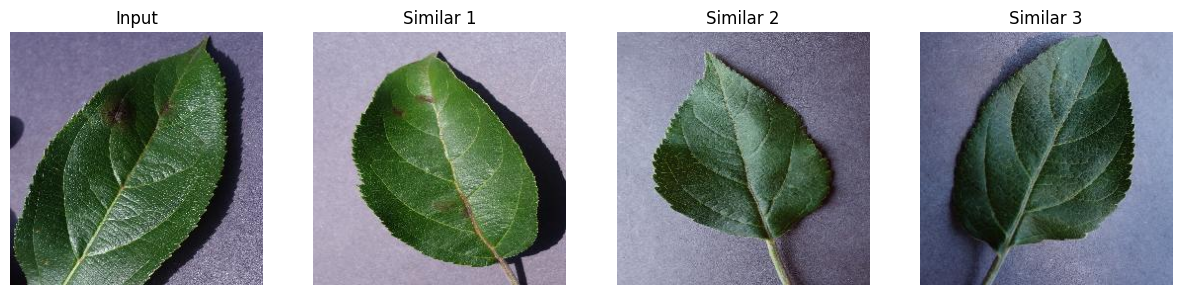

In [15]:
test_img = os.path.join(extract_path, 'test/0/0f1197f8-a106-4ebc-ad08-42967be969a8.JPG')  # <-- sửa lại đúng tên ảnh test của bạn
similar_imgs = search_similar_images(test_img)

show_images(test_img, similar_imgs)


In [16]:
correct = 0
total = 0

test_dir = os.path.join(extract_path, 'test')

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_img_path = os.path.join(root, file)
            test_class = os.path.basename(os.path.dirname(test_img_path))
            try:
                result_paths = search_similar_images(test_img_path)
                result_classes = [os.path.basename(os.path.dirname(p)) for p in result_paths]

                if test_class in result_classes:
                    correct += 1
                total += 1
            except Exception as e:
                print(f"Lỗi với ảnh {test_img_path}: {e}")

accuracy = correct / total if total > 0 else 0
print(f"🎯 Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")


🎯 Accuracy: 94.06% (9921/10547)


🖼️ Ảnh được chọn: D:\HCSDLDPT\data_distribution_for_SVM\test\35\3b08df4f-d655-4361-8152-49783f42d84a.JPG


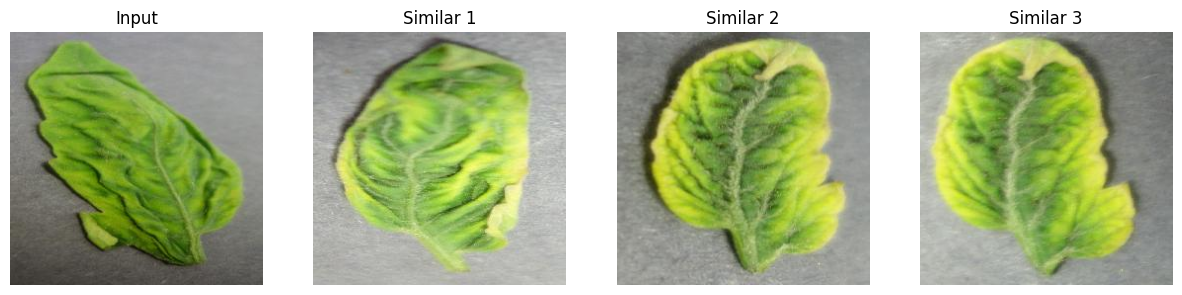

In [17]:
import random
import os

# Lấy ngẫu nhiên 1 ảnh từ test
def get_random_test_image():
    test_images = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(root, file))

    # Check if test_images is empty and handle the case
    if not test_images:
        print("⚠️ Không tìm thấy ảnh nào trong thư mục test. Vui lòng kiểm tra lại đường dẫn.")
        return None  # or raise an exception, depending on your desired behavior

    return random.choice(test_images)

# Test với ảnh được chọn ngẫu nhiên
input_path = get_random_test_image()
if input_path: # Check if input_path is not None
    print(f"🖼️ Ảnh được chọn: {input_path}")
    similar_imgs = search_similar_images(input_path)
    show_images(input_path, similar_imgs)